In [1]:
import warnings
import os
import shutil
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf

In [2]:
root_dir = 'D:/OpenClassrooms/projet_6'


warnings.filterwarnings('ignore')


# for bigger plots
plt.rcParams['figure.figsize'] = 12, 8

# First look

In [3]:
df_path = root_dir + '/data/' + 'photos.json'

df = pd.read_json(df_path, lines=True)
df

,photo_id,business_id,caption,label
0,zsvj7vloL4L5jhYyPIuVwg,Nk-SJhPlDBkAZvfsADtccA,Nice rock artwork everywhere and craploads of ...,inside
1,HCUdRJHHm_e0OCTlZetGLg,yVZtL5MmrpiivyCIrVkGgA,,outside
2,vkr8T0scuJmGVvN2HJelEA,_ab50qdWOk0DdB6XOrBitw,oyster shooter,drink
3,pve7D6NUrafHW3EAORubyw,SZU9c8V2GuREDN5KgyHFJw,Shrimp scampi,food
4,H52Er-uBg6rNrHcReWTD2w,Gzur0f0XMkrVxIwYJvOt2g,,food
...,...,...,...,...
200095,4Zia9NkAfQNjMfcIDhwJ-g,2HxkdqHmbYGj_BH1bLaiSw,#Nektar,food
200096,KB96KRZRhRm8hUkI-OpGEA,_gVyuTRb_6HM-SNtqbpevQ,,inside
200097,Klmojvaf2_2dP1XKzTsFmQ,NUyEOjfAl3HvkpzSpdwqeA,,food
200098,FNEiq7Mogec7t31OaU5juw,hE6YsHHV0fCz_UrGS4o6VA,Drinks by the water!,drink


In [4]:
df['label'].value_counts()

food       108152
inside      56031
outside     18569
drink       15670
menu         1678
Name: label, dtype: int64

In [5]:
imgs_path = root_dir + '/data/photos/'
image_format = 'jpg'

print('nb_images:', len(os.listdir(imgs_path)))

nb_images: 200098


In [19]:
def list_fct(name, list_photos) :
    list_image_name = [list_photos[i] for i in range(len(df)) if df["label"][i]==name]
    return list_image_name

inside


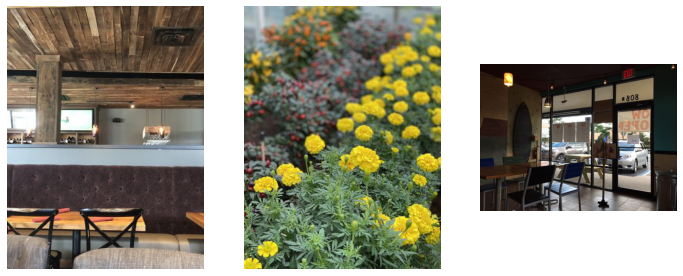

outside


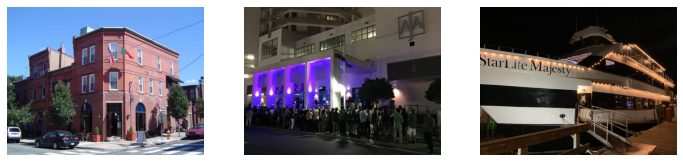

drink


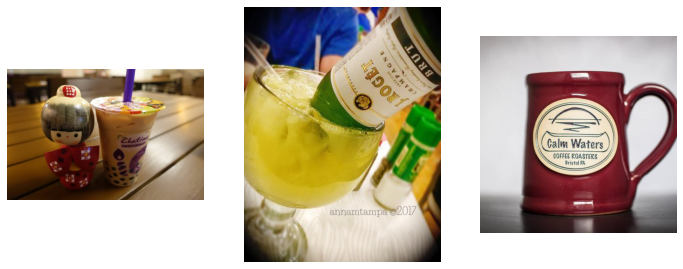

food


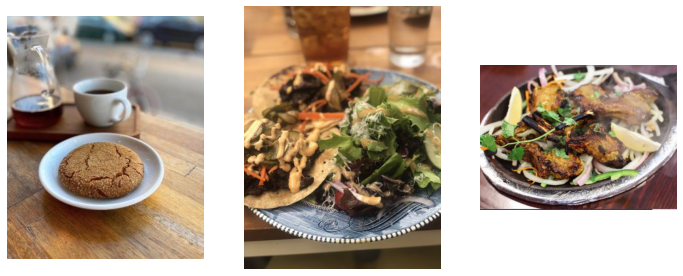

menu


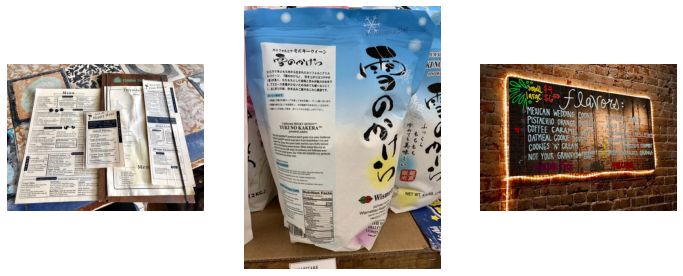

In [20]:
nb_images = 3


labels = list(df['label'].unique())
list_photos = df['photo_id'] + '.' + image_format

from matplotlib.image import imread
for name in labels:
    print(name)
    for i in range(nb_images):
        n = int('1' + str(nb_images) + '0')
        plt.subplot(n + 1 + i)
        filename = imgs_path + list_fct(name, list_photos)[i+10]
        image = imread(filename)
        plt.axis('off')
        plt.imshow(image)
    plt.show()

wZ29mUm6nKz566j17OBadw : 



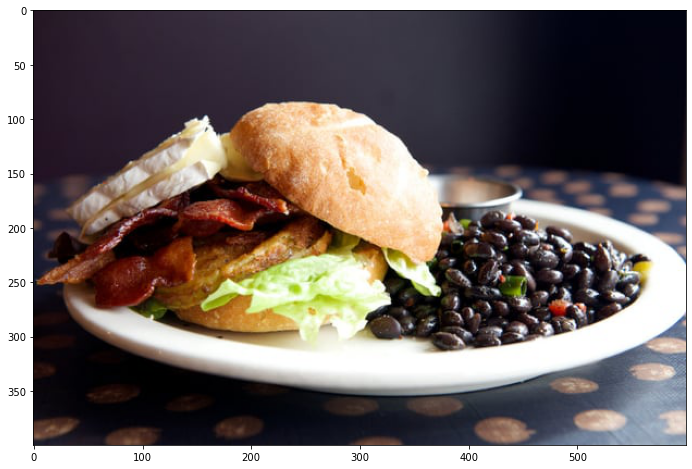

height: 400 px 
 width: 600 px 

(400, 600, 3)


In [21]:
index = 5

img_name = df['photo_id'].loc[index]
print(img_name, ':', '\n')
img = Image.open(imgs_path + img_name + '.' + image_format)
plt.imshow(img)
plt.show()

mat = np.array(img)
print(mat.shape)

# Create dataset

In [22]:
# for each label: create a folder and copy a sample of photos
create_dataset = False
nb_samples_per_label = 200


if create_dataset:
    for i, label in enumerate(labels):
        print(i, ':', label)
        selected_photos_path = root_dir + '/data/model_data/' + str(i)
        if not os.path.isdir(selected_photos_path):
            os.mkdir(selected_photos_path)
        df_label = df[df['label'] == label].sample(nb_samples_per_label, random_state=0)
        
        for i in range(df_label.shape[0]):
            photo_name = df_label['photo_id'].iloc[i] + '.' + image_format
            photo_path = imgs_path + photo_name
            shutil.copy(photo_path, selected_photos_path)

    # check that all photos are readable
    model_data_path = root_dir + '/data/model_data/'
    bad_photos_path = root_dir + '/data/not_valid_photos'

    invalid_photos = []
    for root, dirs, files in os.walk(model_data_path):
        for photo in files:
            img_path = os.path.join(root, photo)
            try:
                Image.open(img_path)
            except:
                invalid_photos.append(photo)
                shutil.copy(img_path, bad_photos_path)

    print('\n', 'Invalid photos:', len(invalid_photos), '\n')

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(include_top=False, weights='imagenet', pooling='avg')

In [24]:
# original model
model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

## Test on one image

In [25]:
input_size_model = (224, 224)

nb_images = 1
from tensorflow.keras.preprocessing.image import load_img, img_to_array
img = load_img(imgs_path + img_name + '.' + image_format, target_size=input_size_model)
img = img_to_array(img)
img = img.reshape((nb_images, img.shape[0], img.shape[1], img.shape[2]))

from tensorflow.keras.applications.vgg16 import preprocess_input
img = preprocess_input(img)

# feature vector
pred = model.predict(img)
print(pred.shape)

1/1 [==============================] - 0s 352ms/step
(1, 512)


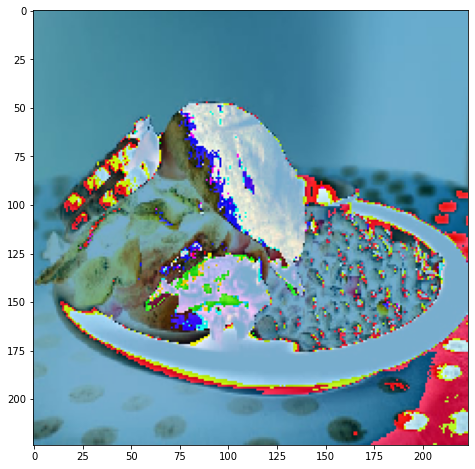

In [27]:
# plot the processed image
img_vgg = img.reshape(img.shape[1:])
img_vgg = (img_vgg*255).astype(np.uint8)
img_vgg = Image.fromarray(img_vgg)

#img_vgg.show()
plt.imshow(img_vgg)
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input


def extract_features(image_path):
    nb_images = 1
    input_size_model = (224, 224)
    
    img = load_img(image_path, target_size=input_size_model)
    img = img_to_array(img)
    img = img.reshape((nb_images, img.shape[0], img.shape[1], img.shape[2]))
    img = preprocess_input(img)

    pred = model.predict(img)
    return pred

In [ ]:
pred = extract_features(imgs_path + img_name + '.' + image_format)
print(pred.shape)

1/1 [==============================] - 0s 190ms/step
(1, 512)


# On all dataset

In [ ]:
input_size_model = (224, 224)
batch_size = 32

data_keras = tf.keras.preprocessing.image_dataset_from_directory(
    root_dir + '/data/model_data',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    image_size=input_size_model, 
    batch_size=batch_size,
)

Found 1000 files belonging to 5 classes.


In [ ]:
# define feature vectors (X) and labels (y)
X_list = []
y_list = []

from tensorflow.keras.applications.vgg16 import preprocess_input
for img_batch, labels_batch in data_keras:
    img_batch = img_batch.numpy()
    img_batch = preprocess_input(img_batch)
    feature_vector_batch = model.predict(img_batch)
    
    X_list.append(feature_vector_batch)
    y_list.append(labels_batch)

X = np.concatenate(X_list, axis=0)
y = np.concatenate(y_list, axis=0)

print('\n')
print(X.shape)
print(y.shape)

1/1 [==============================] - 1s 1s/step


(1000, 512)
(1000,)


In [ ]:
# PCA to reduce dimension but keep variance
kept_variance_percentage = 0.99

from sklearn.decomposition import PCA
pca = PCA(n_components=kept_variance_percentage, random_state=0)
X_pca = pca.fit_transform(X)
print(X_pca.shape)

(1000, 362)


In [ ]:
# use feature vectors from PCA to predict class with K-means
nb_classes = 5

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=nb_classes, random_state=0)
class_pred = kmeans.fit_predict(X_pca)
print(class_pred.shape)

(1000,)


In [ ]:
# ARI score between prediction and true labels
from sklearn.metrics import adjusted_rand_score
score = adjusted_rand_score(y, class_pred)
print('ARI score:', round(score, 3))

ARI score: 0.566


In [ ]:
from sklearn.manifold import TSNE

def tsne_plot(X, pred, s=25, alpha=1):
    tsne = TSNE(n_components=2)
    X_tsne = tsne.fit_transform(X)

    import matplotlib.cm as cm
    colors = cm.rainbow(np.linspace(0, 1, len(np.unique(pred))))
    
    # for bigger plots
    plt.rcParams['figure.figsize'] = 12, 8

    plt.figure()
    for i in np.unique(pred):
        X_tsne_i = []
        for x, p in zip(X_tsne, pred):
            if p == i:
                X_tsne_i.append(x.reshape(1, -1))
        X_tsne_i = np.concatenate(X_tsne_i, axis=0)
        
        plt.scatter(X_tsne_i[:,0], 
                    X_tsne_i[:,1], 
                    color=colors[i], 
                    s=s, 
                    alpha=alpha, 
                    label=str(i))

    plt.legend()
    plt.xlim([np.min(X_tsne[:, 0]), np.max(X_tsne[:, 0])])
    plt.ylim([np.min(X_tsne[:, 1]), np.max(X_tsne[:, 1])])
    plt.show()

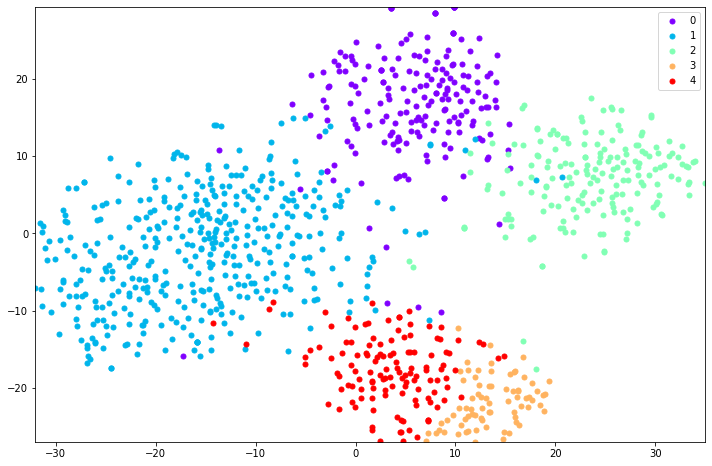

In [ ]:
# tsne: visualize feature vectors from PCA with predictions
tsne_plot(X_pca, class_pred, s=25, alpha=1)

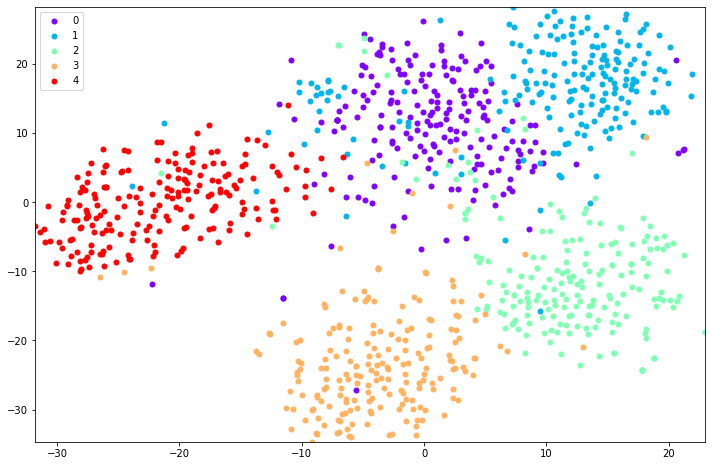

In [ ]:
# tsne: visualize feature vectors from PCA with true labels
tsne_plot(X_pca, y, s=25, alpha=1)

In [9]:
for i, label in enumerate(labels):
    print(i, ':', label)

0 : inside
1 : outside
2 : drink
3 : food
4 : menu


# SIFT

(1027, 128)


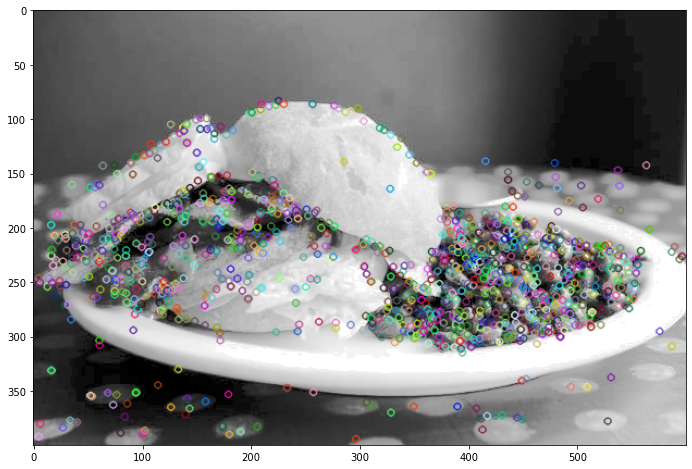

In [ ]:
import cv2

sift = cv2.xfeatures2d.SIFT_create()
img_path = imgs_path + img_name + '.' + image_format
image = cv2.imread(img_path,0) # convert in gray
image = cv2.equalizeHist(image)   # equalize image histogram
kp, des = sift.detectAndCompute(image, None)
img=cv2.drawKeypoints(image,kp,image)

print(des.shape)
plt.imshow(img)
plt.show()

In [ ]:
data_path = root_dir + '/data/model_data/'


sift = cv2.xfeatures2d.SIFT_create()

y_list = []
sift_keypoints = []
for label_dir in os.listdir(data_path):
    for img_name in os.listdir(data_path + label_dir):
        img_path = data_path + label_dir + '/' + img_name
        
        image = cv2.imread(img_path, 0)
        res = cv2.equalizeHist(image)
        kp, des = sift.detectAndCompute(res, None)
        sift_keypoints.append(des)
        y_list.append(int(label_dir))


y = np.array(y_list)
sift_keypoints_by_img = np.array(sift_keypoints)
sift_keypoints_all = np.concatenate(sift_keypoints_by_img, axis=0)

print(sift_keypoints_all.shape)
print(y.shape)

(1402448, 128)
(1000,)


In [ ]:
k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print('Estimated number of clusters:', k)

# Clustering
from sklearn import cluster
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

Estimated number of clusters: 1184


MiniBatchKMeans(init_size=3552, n_clusters=1184, random_state=0)

In [ ]:
def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print('image histogram probleme:', image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist

In [ ]:
# Creation of histograms (feature vectors)
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    hist = build_histogram(kmeans, image_desc, i)
    hist_vectors.append(hist)

im_features = np.asarray(hist_vectors)
print(im_features.shape)

(1000, 1184)


In [ ]:
# PCA to reduce dimension but keep variance
pca = PCA(n_components=kept_variance_percentage, random_state=0)
X_pca = pca.fit_transform(im_features)
print(X_pca.shape)

(1000, 723)


In [ ]:
# use feature vectors from PCA to predict class with K-means
kmeans = KMeans(n_clusters=nb_classes, random_state=0)
class_pred = kmeans.fit_predict(X_pca)
print(class_pred.shape)

(1000,)


In [ ]:
# ARI score between prediction and true labels
score = adjusted_rand_score(y, class_pred)
print('ARI score:', round(score, 3))

ARI score: 0.094


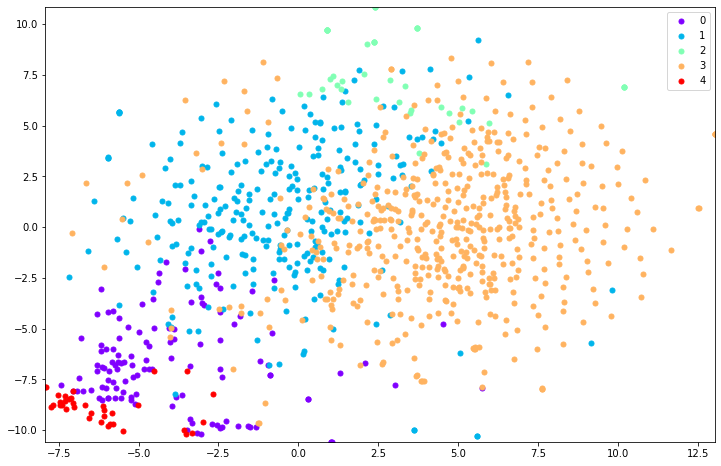

In [ ]:
# tsne: visualize feature vectors from PCA with predictions
tsne_plot(X_pca, class_pred, s=25, alpha=1)

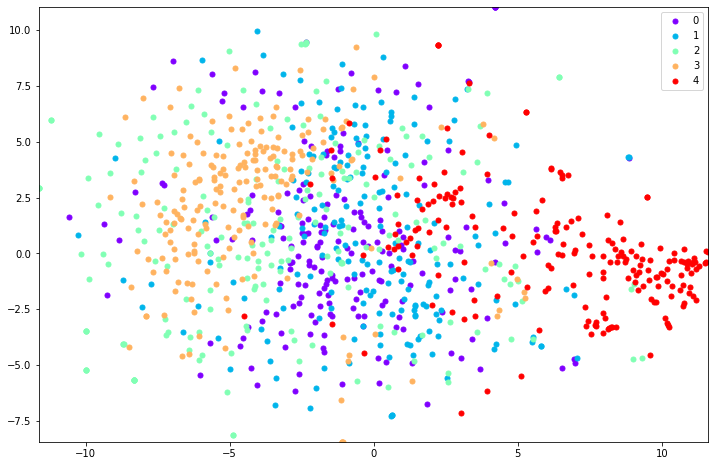

In [ ]:
# tsne: visualize feature vectors from PCA with true labels
tsne_plot(X_pca, y, s=25, alpha=1)

In [10]:
for i, label in enumerate(labels):
    print(i, ':', label)

0 : inside
1 : outside
2 : drink
3 : food
4 : menu
